In [70]:
# Importing the neccesary libraries we are going to need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# preprocess
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# model
from sklearn.linear_model import LogisticRegression

# evaluation
from sklearn import metrics
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# model packing for django
import joblib

import warnings
warnings.filterwarnings('ignore')

# IMPORT DATA

In [71]:
df = pd.read_csv('winedata.csv')
print(df.shape)
df.head(3)

(1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5


# DATA PREPROCESSING

##### DUPLICATED DATA - giá trị lặp

In [72]:
df[df.duplicated(keep='first')]
# df.drop_duplicates()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
4,7.4,0.700,0.00,1.90,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
11,7.5,0.500,0.36,6.10,0.071,17.0,102.0,0.99780,3.35,0.80,10.5,5
27,7.9,0.430,0.21,1.60,0.106,10.0,37.0,0.99660,3.17,0.91,9.5,5
40,7.3,0.450,0.36,5.90,0.074,12.0,87.0,0.99780,3.33,0.83,10.5,5
65,7.2,0.725,0.05,4.65,0.086,4.0,11.0,0.99620,3.41,0.39,10.9,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1563,7.2,0.695,0.13,2.00,0.076,12.0,20.0,0.99546,3.29,0.54,10.1,5
1564,7.2,0.695,0.13,2.00,0.076,12.0,20.0,0.99546,3.29,0.54,10.1,5
1567,7.2,0.695,0.13,2.00,0.076,12.0,20.0,0.99546,3.29,0.54,10.1,5
1581,6.2,0.560,0.09,1.70,0.053,24.0,32.0,0.99402,3.54,0.60,11.3,5


#### MISSING VALUES - giá trị thiếu

In [73]:
df.isnull().sum() #sum nulls

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

#### OUTLIERS DETECTION - giá trị ngoại lai

Data distribution before removing outliers

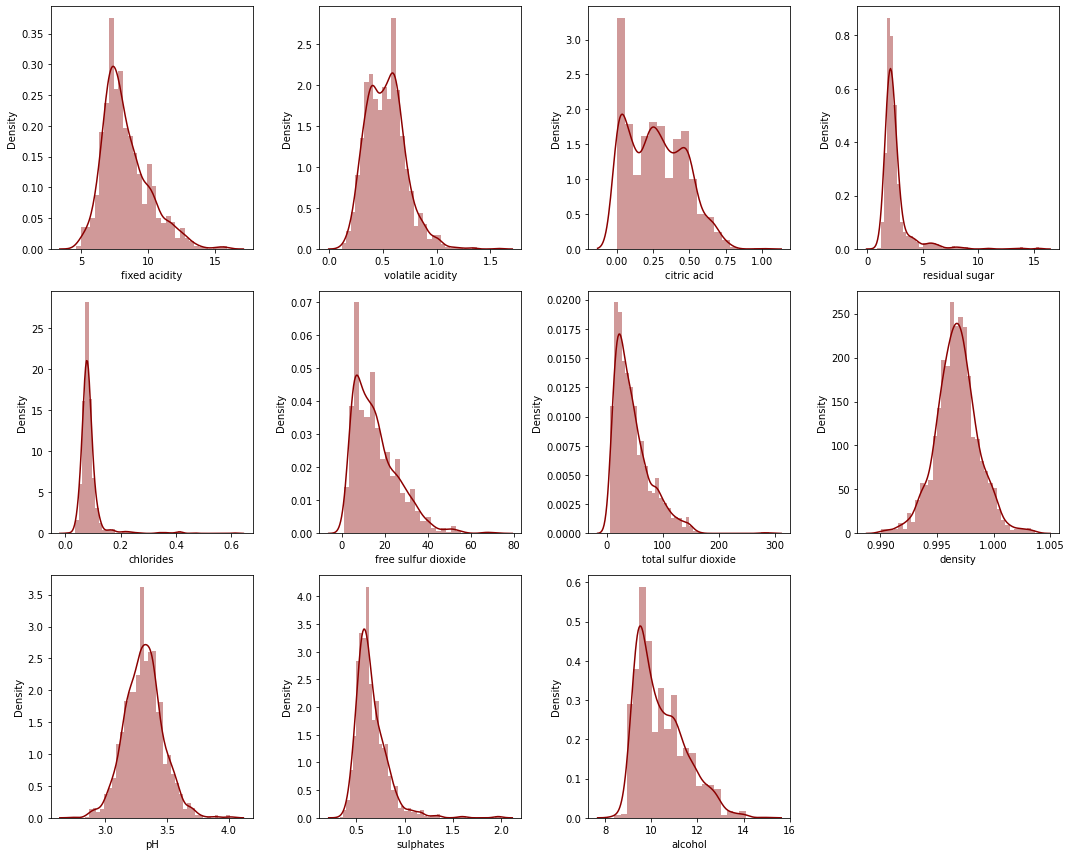

In [74]:
plt.figure(figsize=(15,12))
for ind, col in enumerate(df.columns[:-1]):
    plt.subplot(3,4, ind+1)
    sns.distplot(df[col], color='darkred')
plt.tight_layout()
plt.show()

Shapiro Test to confirm:
- Ho: data follows normal distribution
- H1: data doesnt follow normal distribution

If p<0.05: reject null hypo

In [75]:
from scipy.stats import shapiro
columns = []
stats = []
pvalue = []
check = []
for col in df.columns[:-1]:
    stat, p = shapiro(df[col])
    columns.append(col)
    stats.append(stat)
    pvalue.append(p)
    if p > 0.05:
        check.append('YES')
    else:
        check.append('NO')
df_shapiro = pd.DataFrame({'Columns':columns,'W value':stats, 'P value': pvalue,'Check':check})   
df_shapiro 

,Columns,W value,P value,Check
0,fixed acidity,0.942031,1.525595e-24,NO
1,volatile acidity,0.974334,2.686807e-16,NO
2,citric acid,0.955290,1.020820e-21,NO
3,residual sugar,0.566077,0.000000e+00,NO
4,chlorides,0.484247,0.000000e+00,NO
5,free sulfur dioxide,0.901841,7.697398e-31,NO
6,total sulfur dioxide,0.873225,3.574144e-34,NO
7,density,0.990867,1.940096e-08,NO
8,pH,0.993487,1.713695e-06,NO
9,sulphates,0.833043,5.821618e-38,NO


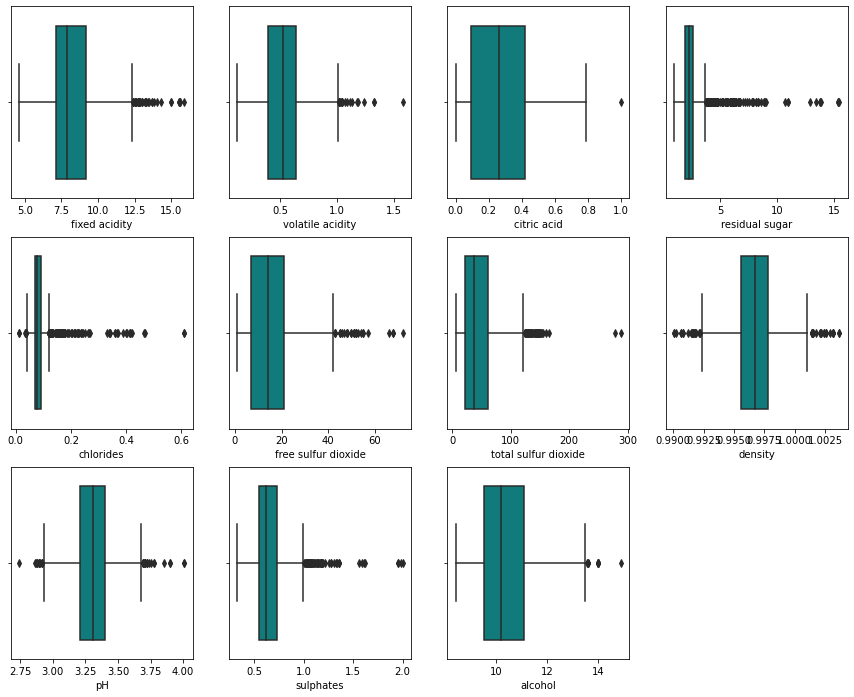

In [76]:
plt.figure(figsize=(15,12))
for ind, col in enumerate(df.columns[:-1]):
    plt.subplot(3,4, ind+1)
    sns.boxplot(data=df, x=col, color='darkcyan')

In [77]:
def iqr_outliers(seri):
    q1 = seri.quantile(0.25)
    q3 = seri.quantile(0.75)
    iqr = q3 - q1
    up_fence = q3 + 1.5*iqr 
    low_fence = q1 - 1.5*iqr 
    return low_fence, up_fence

for col in df.columns[:-1]:
    low, up = iqr_outliers(df[col])
    df = df[(df[col] > low) & (df[col] < up)]
df.shape

(1135, 12)

Distribution after removing outliers

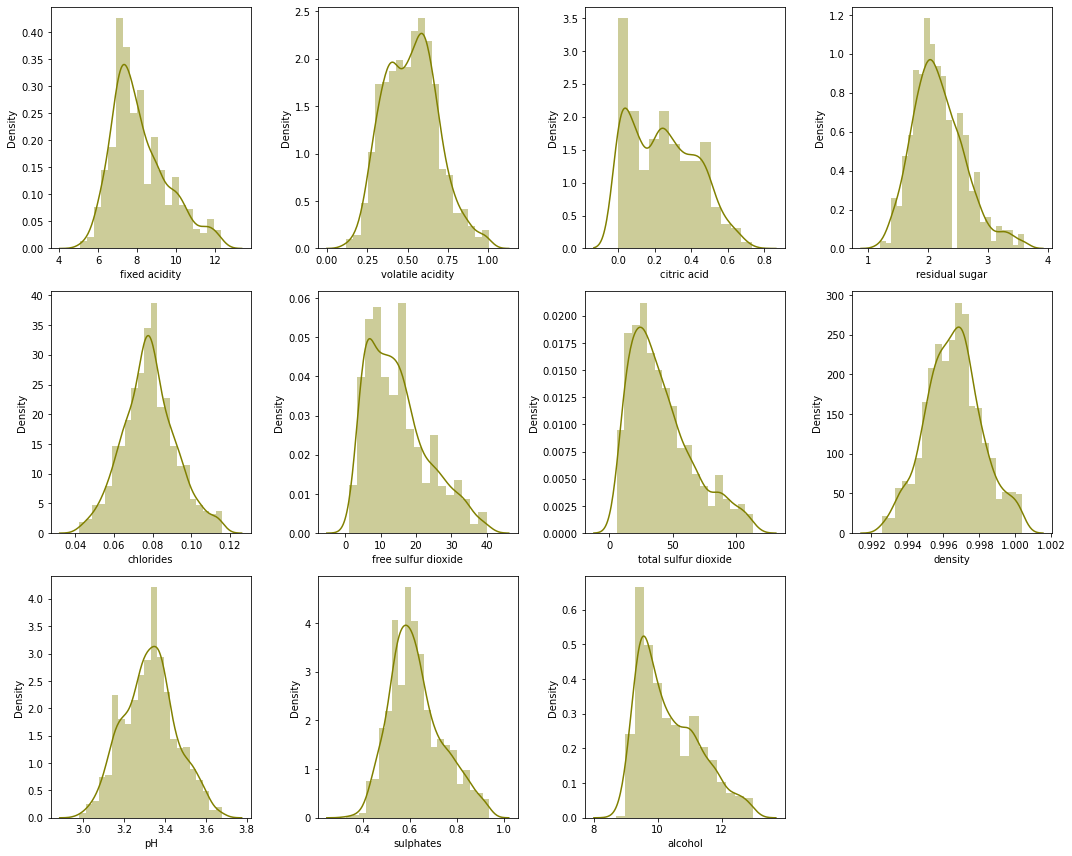

In [78]:
plt.figure(figsize=(15,12))
for ind, col in enumerate(df.columns[:-1]):
    plt.subplot(3,4, ind+1)
    sns.distplot(df[col], color='olive')
plt.tight_layout()
plt.show()

#### FEATURE SELECTION

MULTICOLLINEARITY - đa cộng tuyến

In [79]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# the target column (in this case 'grade') should not be included in variables
# categorical variables may or maynot be added if any
variables = df[['fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol',]]
x = add_constant(variables)
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(x.values,i) for i in range (x.shape[1])]
vif['features'] = x.columns
vif

,VIF,features
0,2.539788e+06,const
1,6.809390e+00,fixed acidity
2,2.060065e+00,volatile acidity
3,3.148410e+00,citric acid
4,1.712597e+00,residual sugar
5,1.286184e+00,chlorides
6,1.906135e+00,free sulfur dioxide
7,2.096684e+00,total sulfur dioxide
8,6.416265e+00,density
9,3.111450e+00,pH


#### LABELING - gán nhãn

In [80]:
grade = [] 
for i in df['quality']: 
    if i > 6.5:
        i = 1
        grade.append(i)
    else:
        i = 0
        grade.append(i)
df['grade'] = grade

#### STANDARDIZATION - chuẩn hóa dữ liệu

In [81]:
# independent variables: biến độc lập
x = df.drop(columns={'grade','quality'}, axis =1 )
# dependent variable: biến phụ thuộc
y = df['grade']

Normalization

In [82]:
# sts = StandardScaler()
# sts.fit(x)
# scaled_x = sts.transform(x)

Min Max

In [83]:
mms = MinMaxScaler()
mms.fit(x)
scaled_x=mms.transform(x)

# LOGISTIC REGRESSION

SPLIT DATASET - chia dữ liệu thành 2 phần train, test

In [84]:
#Splitting our data into train and test dataset
x_train, x_test, y_train, y_test = train_test_split(scaled_x, y , test_size = 0.2, random_state  = 365, stratify=df['grade'])


# x_train, x_test, y_train, y_test = train_test_split(scaled_x, y , test_size = 0.2, random_state  = 365)

In [85]:
y_train.value_counts()

0    797
1    111
Name: grade, dtype: int64

In [86]:
y_test.value_counts()

0    199
1     28
Name: grade, dtype: int64

HANDLING IMBLANCED DATA

In [87]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler 

# define pipeline 
sm = SMOTE(random_state=42) 
x_train, y_train = sm.fit_resample(x_train, y_train)


GENERATING MODEL - tạo mô hình

In [88]:
reg = LogisticRegression() #select the algorithm
reg.fit(x_train,y_train) # we fit the algorithm with the training data and the training output

LogisticRegression()

PREDICTING THE TEST DATA - dự đoán bằng test data

In [89]:
y_hat = reg.predict(x_test) # y_hat holding the prediction made with the algorithm using x_test

EVALUATING

Accuracy = 0.762114537444934
              precision    recall  f1-score   support

           0       0.97      0.75      0.85       199
           1       0.32      0.86      0.47        28

    accuracy                           0.76       227
   macro avg       0.65      0.80      0.66       227
weighted avg       0.89      0.76      0.80       227



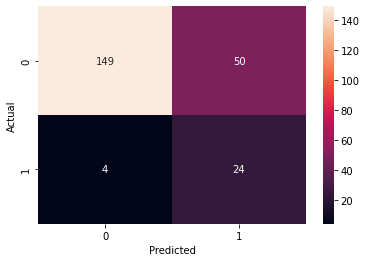

In [90]:
# Accuracy
print('Accuracy = ' + str(accuracy_score(y_test,y_hat)))

# cassification report
print(classification_report(y_test,y_hat))

# confustion matrix
cm = confusion_matrix(y_test, y_hat)
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')
plt.show()

PREDICTING NEW VALUE - dự đoán giá trị mới

In [91]:
reg.predict([[8,0.5,0.2,2.4,0.1,26,70,0.8,3.4,0.7,9]])

array([0], dtype=int64)

# DECISION TREE

In [92]:
from sklearn.tree import DecisionTreeClassifier #for using Decision Tree Algoithm
dd = DecisionTreeClassifier()
dd.fit(x_train,y_train)
y_pred = dd.predict(x_test)

from sklearn.metrics import accuracy_score , confusion_matrix, classification_report
acc_1 = metrics.accuracy_score(y_test, y_pred)
print(f'ACCURACY = {acc_1}')
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

ACCURACY = 0.8325991189427313
[[173  26]
 [ 12  16]]
              precision    recall  f1-score   support

           0       0.94      0.87      0.90       199
           1       0.38      0.57      0.46        28

    accuracy                           0.83       227
   macro avg       0.66      0.72      0.68       227
weighted avg       0.87      0.83      0.85       227



In [93]:
import joblib
joblib.dump(reg,'final_model.sav')

['final_model.sav']